/Users/saeedbidi/Learning/Options/EnergyPricing/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/saeedbidi/Learning/Options/EnergyPricing/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/saeedbidi/Learning/Options/EnergyPricing/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


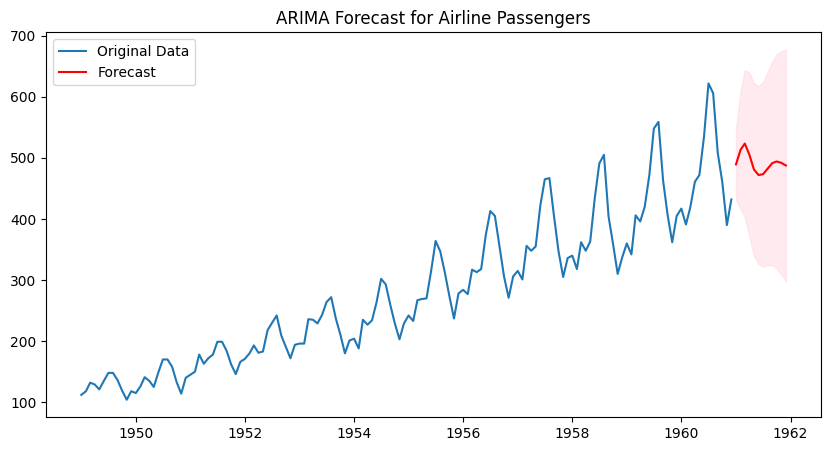

In [44]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Load data from your CSV file
df = pd.read_csv('AirPassengers.csv')  # Replace 'your_file.csv' with your actual file path

# Convert 'Month' to datetime and set it as index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Fit ARIMA model on the Passengers data
model = ARIMA(df['Passengers'], order=(5, 1, 0))  # (p,d,q) = (5,1,0) as an example
model_fit = model.fit()

# Generate forecast for the next 12 periods
forecast = model_fit.get_forecast(steps=12)
forecast_ci = forecast.conf_int()

# Plot the original data
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Passengers'], label='Original Data')

# Plot the forecasted data
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
forecast_values = forecast.predicted_mean

plt.plot(forecast_index, forecast_values, label='Forecast', color='red')

# Plot the confidence intervals
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)

# Add legend and title
plt.legend()
plt.title('ARIMA Forecast for Airline Passengers')

# Show the plot
plt.show()


Training RandomForest...
RandomForest training completed.
Training XGBoost...
XGBoost training completed.
Making predictions with RandomForest...
Making predictions with XGBoost...
RandomForest Evaluation:
RMSE: 2.7317425227485304
MAE: 1.5803326308621017
R-squared: 0.9507881159483208
XGBoost Evaluation:
RMSE: 2.5116683849723445
MAE: 1.4660224147439214
R-squared: 0.958397918146224
Making predictions with RandomForest...
Making predictions with XGBoost...


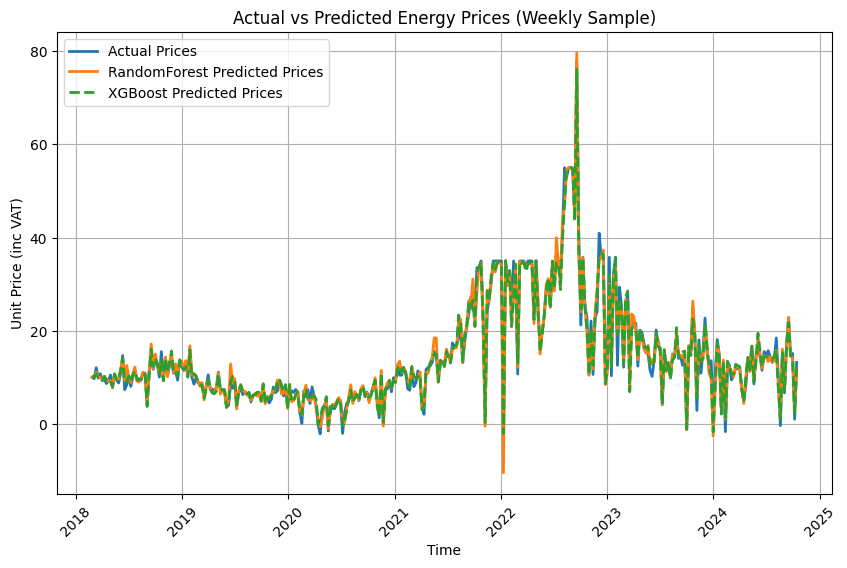

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error, r2_score
import xgboost as xgb


class MLModel:
    def __init__(self):
        self.models = {
            'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
            'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
        }
        self.trained_models = {}  # Dictionary to store trained models
        self.predictions = {}

    def train(self, model_name, X_train, y_train):
        """Train the specified model."""
        if model_name not in self.models:
            raise ValueError(f'Model {model_name} not found.')

        model = self.models[model_name]
        print(f'Training {model_name}...')
        model.fit(X_train, y_train)  # Train the model
        self.trained_models[model_name] = model  # Save the trained model
        print(f'{model_name} training completed.')

    def predict(self, model_name, X_test):
        """Make predictions with the specified model."""
        if model_name not in self.trained_models:
            raise ValueError(f'Model {model_name} has not been trained.')

        model = self.trained_models[model_name]
        print(f'Making predictions with {model_name}...')
        predictions = model.predict(X_test)  # Predict based on the model
        self.predictions[model_name] = predictions
        return predictions


class Plotter:
    @staticmethod
    def plot_predictions(y_test, predictions, title='Actual vs Predicted Energy Prices (Weekly Sample)'):
        """Plot the actual vs predicted results, focusing on weekly samples."""
        
        # Define different line styles for the models
        line_styles = ['-', '--', ':', '-.']
        
        plt.figure(figsize=(10, 6))
        
        # Plot actual prices
        plt.plot(y_test.index, y_test.values, label='Actual Prices', alpha=1, linewidth=2, linestyle='-')
        
        # Plot predictions for each model with different line styles
        for i, (model_name, preds) in enumerate(predictions.items()):
            plt.plot(y_test.index, preds, label=f'{model_name} Predicted Prices', 
                    linewidth=2, linestyle=line_styles[i % len(line_styles)])  # Cycle through line styles

        # Add legend and title
        plt.legend()
        plt.title(title)
        plt.xlabel('Time')
        plt.ylabel('Unit Price (inc VAT)')
        plt.xticks(rotation=45)
        plt.grid(True)  # Add grid for better readability
        plt.show()


class Report:
    @staticmethod
    def evaluate_model(y_test, y_pred, model_name):
        """Evaluate the model performance."""
        rmse = np.sqrt(mse(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f'{model_name} Evaluation:')
        print(f'RMSE: {rmse}')
        print(f'MAE: {mae}')
        print(f'R-squared: {r2}')
        return rmse, mae, r2


# Step 1: Data Preparation
column_names = ['CET Time', 'UK Time (HH:MM)', 'Area Code', 'Area Name', 'Unit Price (inc VAT)']
data = pd.read_csv('csv_agile_C_London.csv', names=column_names, header=None)

# Drop the unnecessary columns ('UK Time (HH:MM)', 'Area Code', 'Area Name')
data = data.drop(columns=['UK Time (HH:MM)', 'Area Code', 'Area Name'])

# Parse the date column and set it as the index
data['CET Time'] = pd.to_datetime(data['CET Time'])
data.set_index('CET Time', inplace=True)

# Extract features
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['unit_price_lag_1'] = data['Unit Price (inc VAT)'].shift(1)

# Drop any rows with missing values (due to lagged features)
data.dropna(inplace=True)
data.to_csv('energy_london.csv')


# Define features and target variable
X = data[['hour', 'day_of_week', 'unit_price_lag_1']]
y = data['Unit Price (inc VAT)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Machine Learning Models
ml_model = MLModel()

# Train models
ml_model.train('RandomForest', X_train, y_train)
ml_model.train('XGBoost', X_train, y_train)

# Predict with models
rf_predictions = ml_model.predict('RandomForest', X_test)
xgb_predictions = ml_model.predict('XGBoost', X_test)

# Store all predictions for plotting
predictions = {'RandomForest': rf_predictions, 'XGBoost': xgb_predictions}

# Step 3: Evaluation
report = Report()
report.evaluate_model(y_test, rf_predictions, 'RandomForest')
report.evaluate_model(y_test, xgb_predictions, 'XGBoost')

# Step 4: Plotting
plotter = Plotter()
# Weekly sampling and plotting for predictions
X_test_weekly = X_test.resample('W').first()
y_test_weekly = y_test.resample('W').first()

# Drop rows with NaN values after resampling
X_test_weekly.dropna(inplace=True)
y_test_weekly.dropna(inplace=True)

# Align X_test_weekly and y_test_weekly by selecting the common indices
common_indices = X_test_weekly.index.intersection(y_test_weekly.index)
X_test_weekly = X_test_weekly.loc[common_indices]
y_test_weekly = y_test_weekly.loc[common_indices]

# Predict for the weekly data using RandomForest and XGBoost
rf_predictions_weekly = ml_model.predict('RandomForest', X_test_weekly)
xgb_predictions_weekly = ml_model.predict('XGBoost', X_test_weekly)

# Store weekly predictions
weekly_predictions = {'RandomForest': rf_predictions_weekly, 'XGBoost': xgb_predictions_weekly}

# Plot weekly predictions
plotter.plot_predictions(y_test_weekly, weekly_predictions, title='Actual vs Predicted Energy Prices (Weekly Sample)')
